### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [ ]:
# < A whole lot of your code > - models, charts, analysis

---

## Area of "copy-paste" from seminar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tqdm
import nltk
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
!unzip Train_rev1.zip
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

--2022-10-07 15:46:57--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.169.138
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.169.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip’

Train_rev1.zip      100%[===================>] 122.41M  29.0MB/s    in 4.8s    

2022-10-07 15:47:03 (25.2 MB/s) - ‘Train_rev1.zip’ saved [128356352/128356352]

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


(244768, 12)

In [ ]:
%%time
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

# columns
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

# tokenizing
tokenizer = nltk.tokenize.WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(str(x).lower()))
data['Title'] = data['Title'].apply(tokenize)
data['FullDescription'] = data['FullDescription'].apply(tokenize)

# word counting
token_counts = Counter()
for i in range(data.shape[0]):
    token_counts.update(data['Title'][i].split())
    token_counts.update(data['FullDescription'][i].split())

# adjust tokens
min_count = 10
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens
token_to_id = {t: i for i, t in enumerate(tokens)}
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

# categorical features encoding
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

# train/test split
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

CPU times: user 38 s, sys: 415 ms, total: 38.4 s
Wall time: 40.4 s


In [ ]:
def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=torch.device('cpu'), **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

---

## Area of experiments and improvements

In [ ]:
def softmax_pooling(tensor):
    weights = torch.softmax(tensor, dim=-1)
    res = (tensor * weights).sum(dim=-1)
    return res

In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=128, embedding_dim=64, kernel=(5,)):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, hid_size, kernel)
        self.conv_2 = nn.Conv1d(embedding_dim, hid_size, kernel)
        self.relu = nn.LeakyReLU(0.2)
        self.batchnorm = nn.BatchNorm1d(hid_size*2)
        self.pooling = softmax_pooling

    def forward(self, batch):
        res_1 = self.conv_1(self.emb(batch).transpose(-1,-2))
        res_2 = self.conv_2(self.emb(batch).transpose(-1,-2))
        res = torch.cat((res_1, res_2), dim=1)
        res = self.batchnorm(res)
        res = self.relu(res)
        res = self.pooling(res)
        return res

class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=128, embedding_dim=64, kernel=(5,)):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, hid_size, kernel)
        self.conv_2 = nn.Conv1d(embedding_dim, hid_size, kernel)
        self.relu = nn.LeakyReLU(0.2)
        self.batchnorm = nn.BatchNorm1d(hid_size*2)
        self.pooling = softmax_pooling

    def forward(self, batch):
        res_1 = self.conv_1(self.emb(batch).transpose(-1,-2))
        res_2 = self.conv_2(self.emb(batch).transpose(-1,-2))
        res = torch.cat((res_1, res_2), dim=1)
        res = self.batchnorm(res)
        res = self.relu(res)
        res = self.pooling(res)
        return res

class CategoricalEncoder(nn.Module):
    def __init__(self, n_cat_features=len(categorical_vectorizer.vocabulary_), out_channels=64):
        super().__init__()
        self.fully_connected = nn.Linear(n_cat_features, out_channels)

    def forward(self, batch):
        return self.fully_connected(batch)

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64, embedding_dim=32):
        super().__init__()
        self.title_encoder = TitleEncoder()
        self.description_encoder = DescriptionEncoder()
        self.categorical_encoder = CategoricalEncoder()
        self.dense = nn.Linear(64*9, 64)
        self.output_fc = nn.Linear(64, 1)
        
    def forward(self, batch):
        te = self.title_encoder(batch['Title'])
        de = self.description_encoder(batch['FullDescription'])
        ce = self.categorical_encoder(batch['Categorical'])
        features = torch.cat((te, de, ce), dim=1)
        output = self.dense(features)
        output = self.output_fc(output).reshape(-1,)
        return output

    def predict(self, batch):
        return self.forward(batch).detach().numpy()

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30
DEVICE = torch.device('cuda')

def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=DEVICE, **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=DEVICE, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [ ]:
!pip install -q lightning-bolts
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

     |████████████████████████████████| 316 kB 5.2 MB/s 
     |████████████████████████████████| 708 kB 56.2 MB/s 
     |████████████████████████████████| 529 kB 53.6 MB/s 
     |████████████████████████████████| 5.9 MB 56.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220929150707 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.1 which is incompatible.


In [ ]:
mae_metric_log = []
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=EPOCHS//6, max_epochs=EPOCHS)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()

    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    _, mae = print_metrics(model, data_val, device=DEVICE)
    mae_metric_log.append(mae)

    if len(mae_metric_log) >= 2:
        if mae > np.mean(mae_metric_log[-2:]):
            print(f'Early stopping! MAE = {mae}')
            break

epoch: 0


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 101.65235
Mean absolute error: 10.06937
epoch: 1


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.74956
Mean absolute error: 0.65763
epoch: 2


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.25891
Mean absolute error: 0.40537
epoch: 3


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.12993
Mean absolute error: 0.27495
epoch: 4


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.09471
Mean absolute error: 0.23295
epoch: 5


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.09957
Mean absolute error: 0.24498
epoch: 6


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.07933
Mean absolute error: 0.21182
epoch: 7


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.07746
Mean absolute error: 0.21010
epoch: 8


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.07207
Mean absolute error: 0.20074
epoch: 9


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.07386
Mean absolute error: 0.20349
epoch: 10


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.07037
Mean absolute error: 0.19874
epoch: 11


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.13076
Mean absolute error: 0.29599
epoch: 12


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06795
Mean absolute error: 0.19371
epoch: 13


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.07040
Mean absolute error: 0.19811
epoch: 14


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06798
Mean absolute error: 0.19332
epoch: 15


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06775
Mean absolute error: 0.19328
epoch: 16


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06527
Mean absolute error: 0.18891
epoch: 17


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06654
Mean absolute error: 0.19116
epoch: 18


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06530
Mean absolute error: 0.18904
epoch: 19


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06491
Mean absolute error: 0.18918
epoch: 20


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06461
Mean absolute error: 0.18857
epoch: 21


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06560
Mean absolute error: 0.18927
epoch: 22


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06508
Mean absolute error: 0.18823
epoch: 23


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06404
Mean absolute error: 0.18702
epoch: 24


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06530
Mean absolute error: 0.18997
epoch: 25


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06418
Mean absolute error: 0.18733
epoch: 26


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06484
Mean absolute error: 0.18813
epoch: 27


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06436
Mean absolute error: 0.18723
epoch: 28


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06361
Mean absolute error: 0.18605
epoch: 29


  0%|          | 0/3059 [00:00<?, ?it/s]

 results:
Mean square error: 0.06368
Mean absolute error: 0.18590


#### Filled after each experiment

In [ ]:
# rough estimation of options
metrics_log_5_epochs = {
    'baseline': [
        0.3827567636837643,
        0.2921743578793357,
        0.25696065598572126,
        0.2388998153879152,
        0.22883909113019366
    ],
    'dropout_01': [
        0.3849931584370021,
        0.29811715781652165,
        0.26952684136510807,
        0.24972879913413612,
        0.2413845898381644
    ],
    'dropout_03': [
        0.37864284902663725,
        0.3030795651274666,
        0.27803472871215834,
        0.26556305967719696,
        0.2549282952491114
    ],
    'parallel_conv': [
        0.33700618501552476,
        0.2697060394068922,
        0.24248046476028517,
        0.23069604405411204,
        0.2226665235156984
    ],
    'parallel_conv+dropout_01': [
        0.3691476468981084,
        0.2890236002803652,
        0.25846643420992155,
        0.24477253598403603,
        0.2361084911983699
    ],
    'parallel_conv+batch_norm': [
        0.4359196739541202,
        0.33517506549515874,
        0.2907648913712363,
        0.25389595653572744,
        0.23591331434867427
    ],
    'parallel_conv+batch_norm+relu': [
        0.41142785191199904,
        0.333088344893931,
        0.2842501857611227,
        0.2575010628600319,
        0.23932148834875597
    ],
    'parallel_conv+batch_norm+leaky_relu': [
        0.4463605581898313,
        0.33389638183932874,
        0.2845204490440005,
        0.25281111317512356,
        0.24022547793591945
    ],
    'parallel_conv+batch_norm+leaky_relu+softmax_pooling': [
        0.588306153799996,
        0.3364324640223475,
        0.26484054226927317,
        0.23652238421528374,
        0.22460849726273643],
    'parallel_conv+batch_norm+leaky_relu+softmax_pooling+x2_emb_size+extra_fc_layer': [
        0.3192031996874617,
        0.25312292933800096,
        0.24281346630893288,
        0.22014683906064877,
        0.21197612251424808
    ],
}

In [ ]:
# most promissing 2 options with Warmup_LR and Early_Stopping
metrics_log_30_epochs = {
    'parallel_conv+batch_norm+leaky_relu+softmax_pooling': [
        10.133130719655187,
        1.1930959740266371,
        0.6953027650958042,
        0.3971998106640928,
        0.30383948611196226,
        0.24405594330264124,
        0.2331011239505454,
        0.21891609182855334,
        0.21522480766382726,
        0.21122687401693427,
        0.20972504561042,
        0.20203686512465785,
        0.20035901049965274,
        0.198423460193498,
        0.19691068001976345,
        0.19640119343541895,
        0.19530621619913593,
        0.19975740139978346,
        0.19653949690015116,
        0.1974302605826388,
        0.1924142115557462,
        0.19201946917003718,
        0.19125426181338603,
        0.1910432258472239,
        0.19159268937420845,
        0.19172534739245006,
        0.19102636930204886,
        0.19109365584272991,
        0.19082293374264617,
        0.1911607030005209
    ],
    'parallel_conv+batch_norm+leaky_relu+softmax_pooling+x2_emb_size+extra_fc_layer': [
        10.069369969767537,
        0.657630481229828,
        0.4053713849991829,
        0.27494820552202065,
        0.23294558491772888,
        0.2449844496874617,
        0.21182325659037055,
        0.21010390893108838,
        0.2007359787057748,
        0.20348714641551252,
        0.1987441933690301,
        0.2959929338958512,
        0.193714140443069,
        0.19811246192216161,
        0.19332151260622216,
        0.19327999962337092,
        0.1889050578732075,
        0.19116447328103933,
        0.1890388529601769,
        0.18918437780875924,
        0.1885704205414777,
        0.18927213158654044,
        0.18823183339206193,
        0.1870159478477244,
        0.1899694339967112,
        0.18732931999938718,
        0.18812774173203414,
        0.18723155203737182,
        0.1860493197376619,
        0.1859045130377497  
    ],
}

---

## Metrics comparison

* Rough estimation of options

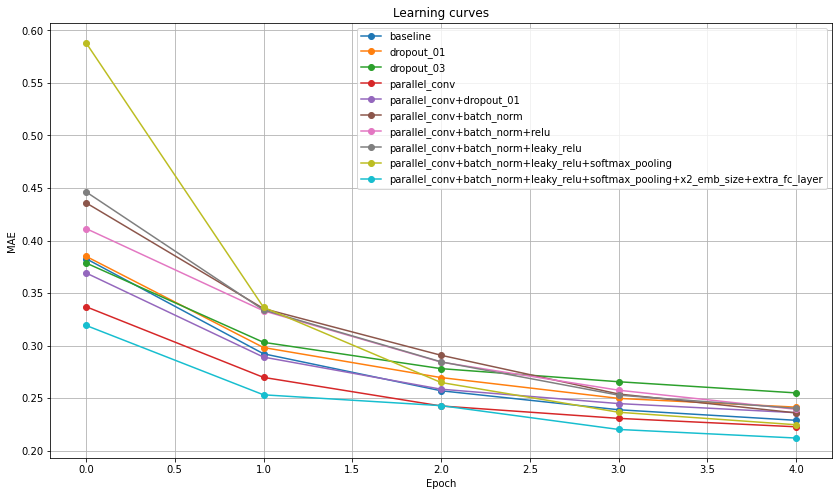

In [ ]:
plt.figure(figsize=(14,8))

for name, metrics in metrics_log_5_epochs.items():
    plt.plot(metrics, 'o-', label=name)

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Learning curves')
plt.legend()
plt.grid()

* Most promissing 2 options with WarmUp_LR and Early_Stopping

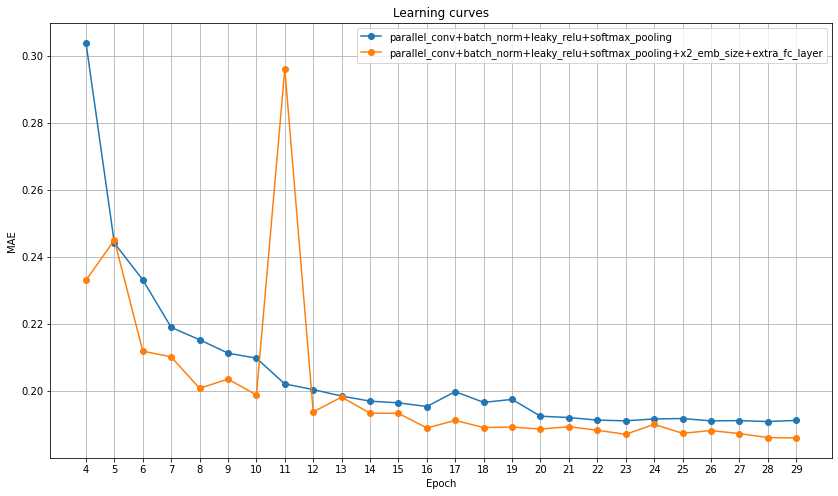

In [ ]:
plt.figure(figsize=(14,8))
shift = 4
limit = 30

for name, metrics in metrics_log_30_epochs.items():
    plt.plot(metrics[shift:], 'o-', label=name)
    
plt.xticks(range(limit-shift), range(shift, limit))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Learning curves')
plt.legend()
plt.grid()

---

### A short report

__General strategy__
1. Try different options/architectures with the same optimizer (AdamW, lr=1e-4) and number of epochs (5)
2. Choose 2 most promissing options and teach them longer

__Steps__

0. __Baseline: MAE = 0.228__
  - same as seminar notebook
  - TitleEncoder & DescriptionEncoder architecture:
    - Emb(32) -> Conv(32, 64, 3) -> MaxPooling()
  - CategoricalEncoder architecture:
    - Linear(n_cat_features, 64)
  - Final layer after concat
    - Linear(64*3, 1) 
1. __Chosen from A: final MAE = 0.222__
  - Dropout 0.1 and 0.3 before final FC layer ⇒ MAE = 0.241 and 0.254 → __worse__
  - Two parallel Conv for both encoders ⇒ MAE = 0.222 → __better__
  - Two parallel Conv + Dropout 0.1 ⇒ MAE = 0.236  → __worse__
  - Two parallel Conv + BatchNorm ⇒ MAE = 0.235  → __worse__ 
  - Two parallel Conv + BatchNorm + ReLU ⇒ MAE = 0.239  → __worse__ 
  - Two parallel Conv + BatchNorm + LeakyLU ⇒ MAE = 0.240  → __worse__ 
2. __Chosen from B: final MAE = 0.211__
  - Two parallel Conv + BatchNorm + LeakyLU + Softmax-pooling ⇒ MAE = 0.224  → __better__ (*)
  - Two parallel Conv + BatchNorm + LeakyLU + Softmax-pooling + x2 Embeddings size + Extra FC layer ⇒ MAE = 0.211  → __better__ (**)
3. __Chosen from E: final MAE = 0.186__
  - Choose the best 2 options and add to them: Linear Warmup Cosine Annealing Learning Rate + more epochs + simple early stopping
    - (*) ⇒ MAE = 0.191 → __better__ 
    - (**) ⇒ MAE = 0.186  → __better__ (by the way, a strange spike at 11-th epoch, probably calculation corner case)

As a result, improved MAE from 0.228 to 0.186.
---


---

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!